In [1]:
%reload_ext autoreload
%autoreload 2

import vaex as vx
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import scipy as sc
from scipy.interpolate import PchipInterpolator as minterp
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
import ipyvolume as ipv
import plotly
import plotly.graph_objs as go
# Configure Plotly to be rendered inline in the notebook.

plotly.offline.init_notebook_mode(connected=True)
cm = sns.light_palette("green", as_cmap=True)

from tqdm import tqdm

import os
import sys
import re
import gc
from numba import jit
from collections import Counter
from collections import namedtuple
from collections import defaultdict

from sklearn.covariance import OAS
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import LedoitWolf
from sklearn.covariance import EmpiricalCovariance

import tensorflow as tf

from umap import UMAP
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA, MiniBatchDictionaryLearning as DL, NMF, FastICA as ICA 
from sklearn.decomposition import FactorAnalysis as FA, SparsePCA as SPCA

from omic_helpers import omic_helpers as hlp


from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier as HB
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as mlpc
from sklearn.neural_network import MLPRegressor as mlpr
from sklearn.svm import SVC

from xgboost import XGBRegressor as xgbr
from lightgbm import LGBMRegressor as lgbmr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, HuberRegressor, ARDRegression
from pygam import GAM, LinearGAM, ExpectileGAM, s, f, l, te
from ngboost import NGBRegressor as ngbr
from ngboost.distns import LogNormal, Normal,Bernoulli
from ngboost.learners import default_tree_learner
from ngboost.scores import MLE
from pyearth import Earth
from interpret.glassbox import ExplainableBoostingRegressor as ebr
from interpret import show as eb_show

from sklearn.inspection import permutation_importance, partial_dependence, plot_partial_dependence
from shap import TreeExplainer, force_plot, dependence_plot, summary_plot, KernelExplainer, LinearExplainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, average_precision_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import AffinityPropagation

from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import cdist
from scipy.cluster import hierarchy

from sklearn.feature_selection import mutual_info_classif as Minfo, f_classif as Fval, chi2
from scipy.stats import ks_2samp as ks, wasserstein_distance as wass

#from keras.models import Sequential
#from keras.layers.core import Dense, Activation, Dropout, Flatten
#from keras.layers import MaxPooling1D
#from keras.callbacks import Callback
#from keras.layers.convolutional import Conv1D
#from keras.layers import Input 

In [ ]:
# also try TabNet: https://towardsdatascience.com/modelling-tabular-data-with-googles-tabnet-ba7315897bfb

In [2]:
def simple_1dcnn(dims=None, conv_layers=[(32,3,3,1), (32,3,3,1), (32,3,3,1), (32,3,3,1), (32,3,3,1)], init_dropout=0.55, final_dropout=0.55):
    num_feats = dims[1]
    model = Sequential()
    model.add(Dropout(init_dropout, input_shape=(num_feats, 1)))
    #model.add(Conv1D(conv_layers[0][0], conv_layers[0][1], input_shape=(num_feats, 1)))
    for _l in conv_layers:
        model.add(Conv1D(filters=_l[0], kernel_size=_l[1], strides=_l[3]))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=_l[2]))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(final_dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', dice_loss])
    
    return model

def simple_dnn(dims=None, conv_layers=[(128,0.05), (64,0.05), (48,0.05), (32,0.1)], init_dropout=0.25, final_dropout=0.5):
    num_feats = dims[1]
    model = Sequential()
    model.add(Dropout(init_dropout, input_shape=(num_feats, )))
    #model.add(Conv1D(conv_layers[0][0], conv_layers[0][1], input_shape=(num_feats, 1)))
    for _l in conv_layers:
        model.add(Dense(_l[0], activation='relu'))
        model.add(Dropout(_l[1]))
        
    model.add(Dropout(final_dropout))    
    model.add(Dense(1,  activation='sigmoid'))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', dice_loss])     # 'binary_crossentropy'     
    return model

@jit
def _diff_entropy(x, eps=1e-6, bins=20):
    rhos, xs = np.histogram(x, density=True, bins=bins)
    xmean =  (xs[1:] + xs[:-1])/2
    xdiff = xs[1:] - xs[:-1]
    H = -np.sum(rhos*np.log(rhos+eps)*xdiff)
    Hr = H/np.sum(xdiff)
    return Hr

@jit
def _ssqrt(x, y):
    return np.sign(x*y)*np.sqrt(np.multiply(np.abs(x), np.abs(y)))
@jit
def _divisor(x, y, eps=1e-3):    
    return np.sign(x)*np.divide((x**2), (x**2+y**2+eps))
@jit
def _sum(x, y):
    return x+y

@jit
def _hmean(x ,y, eps=1e-6):
    return 1/(1/(x+eps)+1/(y+eps))


def pairwise_expander(x, y=None, fun=None):
    '''
        x : np array 
        fun : expansion function, assumes pairwise expansion
    '''
    if y is None:
        num_rows, num_cols = x.shape[0], x.shape[1]
        _num_cols = np.int((num_cols**2-num_cols)/2)
        xex = np.zeros(shape=(num_rows, _num_cols)) 
        k=0
        for jl in range(0, num_cols):
            for jr in range(jl+1, num_cols):                
                xex[:, k] =   fun(x[:,jl], x[:,jr])
                k +=1
    else:
        num_rows_l, num_rows_r, num_cols_l, num_cols_r = x.shape[0], y.shape[0], x.shape[1], y.shape[1]
        _num_cols = np.int(num_cols_l*num_cols_r)
        xex = np.zeros(shape=(num_rows_l, _num_cols))
        k=0
        for jl in range(0, num_cols_l):
            for jr in range(0, num_cols_r):               
                xex[:, k] =   fun(x[:,jl], y[:,jr])
                k +=1
    return xex

def pairwise_bulk_expansion(x, y=None, cols_l=None, cols_r=None, fun=None, index_c=None):
    if "DataFrame" in str(type(x)):
        index_c = x.index
        x = x.values
    else:
        assert ("list" in str(type(index_c))) or \
                ("ndarray" in str(type(index_c))), "index_c should be a vector"
        assert len(index_c) == x.shape[0], "length of index_c should be equal to len(x)"
    if fun is None:
        fun = _ssqrt
        
    def _cols_(cols_l, cols_r=None, prefix=None):
        '''
        x : left/intra data 
        y : right data
        cols_l: left/intra column-names
        cols_r: right column-names
        fun : pairwise combination function
        '''
        prefix = prefix+"_" if prefix is not None else ""
        ms = len(cols_l)+1 if cols_r==None else 0
        cols_r = cols_l if cols_r is None else cols_r
        return [prefix+cols_l[jl]+"_"+cols_l[jr] 
                for jl in range(0, len(cols_l)) 
                for jr in range(np.min([jl+1, ms]), len(cols_r))]
    
    ecols = _cols_(cols_l, cols_r)
    ex = pairwise_expander(x, y, fun=fun)
    
    new = pd.DataFrame(data=ex, columns=ecols, index=index_c)
    old = pd.DataFrame(data=x, columns=cols_l, index=index_c)
    return old.join(new, how='inner')
    


In [3]:
pre_filter = True # filter out weak univariates for classification
x_transform = MinMaxScaler() # MinMaxScaler, QuantileTransformer
x_reducer = None # PCA(n_components=10)
rem_coll = True
outlier_replacer = True
min_var_init = 1e-2
min_var_quantile = 0.99 # to filter after the feature combiner
feature_combiner = True
combiner_function = _ssqrt

viz_reduced = False

In [4]:
# Load gene list
genes = pd.read_csv('../../_meta_data/gene_types/selected_genes.csv', sep='\t')
genes.Symbol = genes.Symbol.str.upper()

In [5]:
os.chdir('/media/bramiozo/DATA-FAST/genetic_expression/hackathon_2/Lung/')

We start with RNA expression, methylation and DNA mutations separately.

The differentiation targets are the treatment response, the cancer types and the tissue type.

We use :

* statistical difference
* geometric difference
* multivariate classification

# Load data

In [6]:
# RNA 
# Methylation
# mutation
# Load meta data: immunoresponse, age, gender

dd = {}
dd['RNAex'] = vx.open('Lung_GeneExpression.hdf5')
dd['mutation'] = vx.open('Lung_Mutation.hdf5')
dd['methylation'] = vx.open('Lung_Methylation.hdf5')
dd['methylation_meta'] = vx.open('HumanMethylation450_meta.hdf5')
dd['CNV'] = vx.open('Lung_CNV.hdf5')

miRNA = pd.read_csv('Lung_miRNA.txt', sep="\t")
mimamap = miRNA[['MIMATID', 'Name', 'Chr', 'Start', 'Stop', 'Strand']]
miRNA.drop(['Name', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
miRNA = miRNA.set_index('MIMATID').transpose()

proteome = pd.read_csv("Lung_Proteome.txt", sep="\t")
proteome = proteome.set_index('sample').transpose()

meta = pd.read_csv('Lung_Phenotype_Metadata.txt', sep='\t')
meta = meta.loc[~pd.isna(meta.Diagnosis)]
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta['SampleID']  = meta.SampleID.str.replace("\-", "_")
meta.set_index('SampleID', inplace=True)

In [7]:
granzyms = list(set(dd['RNAex'][dd['RNAex'].Gene.str.contains('(GZM)|(SECT)|(PRF)')].Gene.tolist()))
tmp = pd.DataFrame([{'Symbol':_int, 'gene_class': 'granzyms'} for _int in granzyms])
genes = pd.concat([genes, tmp])

In [8]:
interferons = list(set(dd['RNAex'][dd['RNAex'].Gene.str.contains('IFN')].Gene.tolist()))
tmp = pd.DataFrame([{'Symbol':_int, 'gene_class': 'interferon'} for _int in interferons])
genes = pd.concat([genes, tmp])

In [9]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 
             'Overall Survival Status', 'Pack Years', 'Smoking Status',
             'Time To Overall Survival (Days)']
meta_cols = meta_cols + ['New Tumor Event', 'Radiation Therapy', 'Reponse To Therapy', 'Drug Therapy Type']

stage_map = {'stage i': 'stage 1', 'stage ia': 'stage 1', 'stage ib': 'stage 1',
             'stage ii': 'stage 2', 'stage iia': 'stage 2', 'stage iib': 'stage 2',
             'stage iii': 'stage 3','stage iiia': 'stage 3', 'stage iiib': 'stage 3',
             'stage iv' : 'stage 4'}
meta['Stage'] = meta['Tumor Stage'].map(stage_map)
########
smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
             'Current Reformed Smoker for > 15 yrs': 'reformed',
             'Current Reformed Smoker, Duration Not Specified': 'reformed',
             'Current Smoker': 'current',
             'Lifelong Non-Smoker': 'non-smoker'}
meta['Smoking'] = meta['Smoking Status'].map(smoke_map)
########
response_map = {'Progressive Disease': 0,
                'Complete Remission/Response': 1,
                'Stable Disease': 0,
                'Partial Remission/Response': 1}
meta['Response'] = meta['Reponse To Therapy'].map(response_map)

meta['Overall Survival Status'] =  meta['Overall Survival Status'].astype(int)

gender_map = {'male': 0, 'female': 1}
meta['Gender'] = meta['Gender'].map(gender_map)

meta_cols = list(set(meta_cols + ['Stage', 'Smoking', 'Response', 'Sample Type']))

In [10]:
dd['RNAex'].Gene = dd['RNAex'].Gene.str.upper()
RNAex = dd['RNAex'].to_pandas_df()
RNAex = RNAex.loc[RNAex.Gene.isin(genes.Symbol)]
RNAex.sort_values(by='Gene', inplace=True)
RNAex.Start = RNAex.Start.astype(str)
RNAex.Stop = RNAex.Stop.astype(str)
RNAex['rnaID'] = RNAex[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
rnamap = RNAex[['rnaID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
rnamap['rnaID'].reset_index(drop=True, inplace=True)
RNAex.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
RNAex = RNAex.set_index('rnaID').transpose()
gc.collect()

3462

In [11]:
low_var_list = RNAex.loc[:, rnamap['rnaID']].columns[RNAex.loc[:, rnamap['rnaID']].var()<=min_var_init].tolist()
rnaID_include = list(set(rnamap.rnaID) - set(low_var_list))
cols = rnaID_include

In [12]:
dd['mutation'].Gene = dd['mutation'].Gene.str.upper()
mutation = dd['mutation'].to_pandas_df()
mutation = mutation.loc[mutation.Gene.isin(genes.Symbol)]
mutation.set_index('Sample_ID', inplace=True)
gc.collect()

98

In [13]:
dd['methylation'].Gene = dd['methylation'].Gene.str.upper()
methylation = dd['methylation'].to_pandas_df()
methylation = methylation.loc[methylation.Gene.isin(genes.Symbol)]
probemap = methylation[['probeID', 'Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']]
probemap.reset_index(drop=True, inplace=True)
methylation.drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'], axis=1, inplace=True)
methylation = methylation.set_index('probeID').transpose()
gc.collect()

5

In [14]:
methylation_meta = dd['methylation_meta'].to_pandas_df()
methylation_meta = methylation_meta.loc[methylation_meta.IlmnID.isin(methylation.columns)]
gc.collect()

209

In [15]:
dd['CNV'].Gene = dd['CNV'].Gene.str.upper()
CNV = dd['CNV'].to_pandas_df()
CNV = CNV.loc[CNV.Gene.isin(genes.Symbol)]
CNV.Start = CNV.Start.astype(str)
CNV.Stop = CNV.Stop.astype(str)
CNV.Start.fillna("nan", inplace=True)
CNV.Stop.fillna("nan", inplace=True)
CNV.Strand.fillna("nan", inplace=True)
CNV.Chr.fillna("nan", inplace=True)
CNV['cnvID'] = CNV[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
cnvmap = CNV[['cnvID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
cnvmap.reset_index(drop=True, inplace=True)
CNV.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
CNV = CNV.set_index('cnvID').transpose()
gc.collect()

5

In [16]:
# deal with with multicollinearity
# 1. replace collinear cliques
# 2. only keep exemplar features

In [200]:
assoc = hlp.association_ruler(num_bins=4, debug=True)

In [208]:
assoc_pairs = assoc.association_rules(RNAex, min_support=10, pre_ordered=False, 
                                      sample_column=None, debug=True) 
gc.collect()

Creating item/order array
Starting order_item:                 921620
Items with support >= 5:            5407
Remaining order_item:                921620
Remaining orders with 2+ items:        1135
Remaining order_item:                921620
Item pairs:                        29066903
Item pairs with support >= 5:     425516



0

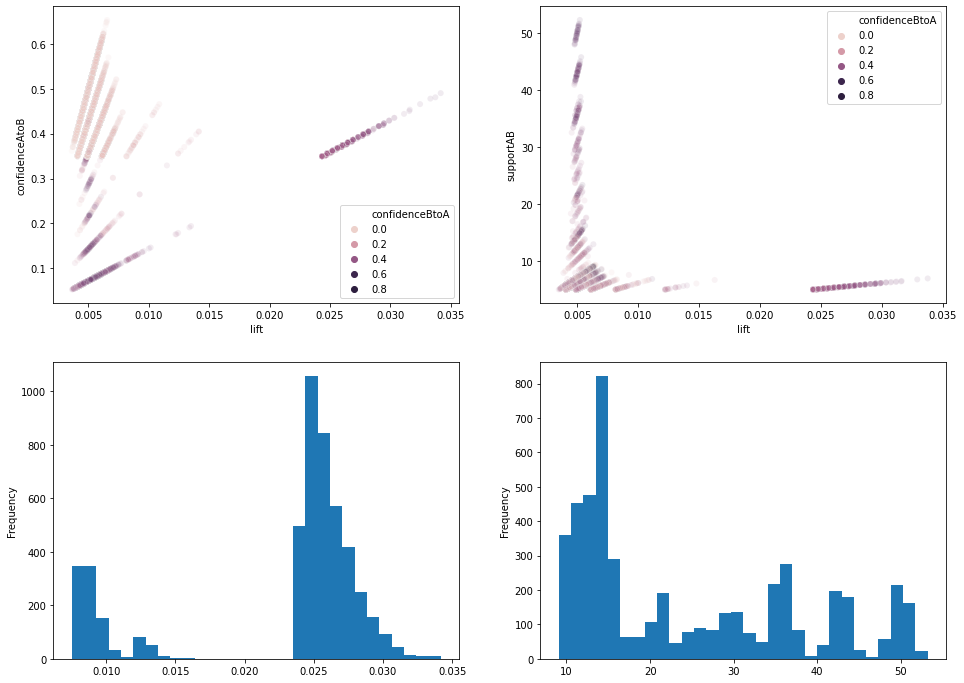

In [250]:
fig, ax = plt.subplots(figsize=(16,12), ncols=2, nrows=2)
sns.scatterplot(data=assoc_pairs.sample(50000), x='lift', y='confidenceAtoB', 
                alpha=0.1, hue='confidenceBtoA', ax=ax[0,0])

sns.scatterplot(data=assoc_pairs.sample(50000), x='lift', y='supportAB', 
                alpha=0.1, hue='confidenceBtoA', ax=ax[0,1])

assoc_pairs.sort_values(by='lift', ascending=False)[:5000].lift.plot.hist(bins=30, ax=ax[1,0])

assoc_pairs.sort_values(by='supportAB', ascending=False)[:5000].supportAB.plot.hist(bins=30, ax=ax[1,1])

In [18]:
# 3 class problem: LA+primary tumor, LSCC+primary tumor, normal tissue
def make_target(x):
    if (x[0]=='Lung Squamous Cell Carcinoma') and (x[1]=='Primary Tumor'):
        return 'LSCC-tumor'
    elif (x[0]=='Lung Adenocarcinoma') and (x[1]=='Primary Tumor'):
        return 'LA-tumor'
    elif (x[1]=='Solid Tissue Normal'):
        return 'normal-tissue'
        
RNAex['y'] = RNAex[['Diagnosis', 'Sample Type']].apply(lambda x: make_target(x), axis=1)

In [19]:
# short exploratory
# 1. dimension reduction
# 2. plot the differential targets
if viz_reduced:
    red = 'UMAP'
    reduceR = UMAP(n_components=3, random_state=323, n_neighbors=50) #UMAP(n_components=3)
    reduceR.fit(RNAex.loc[:, rnaID_include])


    fig = go.Figure(layout={'title': 'RNA expression:'+red+' components'})
    # Configure the trace.
    reduceD = reduceR.transform(RNAex.loc[(RNAex['Diagnosis']=='Lung Adenocarcinoma') & 
                                          (RNAex['Sample Type']=='Primary Tumor'), rnaID_include])
    fig.add_trace(go.Scatter3d(
        x=reduceD[:,0], 
        y=reduceD[:,1],
        z=reduceD[:,2], 
        mode='markers',
        marker={
            'size': 3,
            'opacity': 0.5,
        },
        name='Lung Adenocarcinoma, primary tumor'
    )
    )

    reduceD = reduceR.transform(RNAex.loc[(RNAex['Diagnosis']=='Lung Squamous Cell Carcinoma') & 
                                          (RNAex['Sample Type']=='Primary Tumor'), rnaID_include])
    fig.add_trace(go.Scatter3d(
        x=reduceD[:,0], 
        y=reduceD[:,1],
        z=reduceD[:,2], 
        mode='markers',
        marker={
            'size': 3,
            'opacity': 0.5,
        },
        name='Lung Squamous Cell Carcinoma, primary tumor'
    )
    )

    reduceD = reduceR.transform(RNAex.loc[(RNAex['Sample Type']=='Solid Tissue Normal'), rnaID_include])
    fig.add_trace(go.Scatter3d(
        x=reduceD[:,0], 
        y=reduceD[:,1], 
        z=reduceD[:,2], 
        mode='markers',
        marker={
            'size': 3,
            'opacity': 0.5,
        },
        name='normal tissue'
    )
    )


    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )
    plotly.offline.iplot(fig)

In [20]:
# short exploratory
# 1. dimension reduction
# 2. plot the differential targets
if viz_reduced:
    red = 'TSNE'
    reduceR = TSNE(n_components=3, random_state=123, perplexity=40) #UMAP(n_components=3)
    #reduceR = PCA(n_components=3)
    reduceDat = pd.DataFrame(data=reduceR.fit_transform(RNAex.loc[:, rnaID_include]),
                           columns=['red1', 'red2', 'red3'],
                           index=RNAex.index)

    fig = go.Figure(layout={'title': 'RNA expression:'+red+' components'})
    # Configure the trace.
    reduceD = reduceDat.loc[(RNAex['Diagnosis']=='Lung Adenocarcinoma') & 
                          (RNAex['Sample Type']=='Primary Tumor'), :].values
    fig.add_trace(go.Scatter3d(
        x=reduceD[:,0],  
        y=reduceD[:,1],  
        z=reduceD[:,2],  
        mode='markers',
        marker={
            'size': 3,
            'opacity': 0.5,
        },
        name='Lung Adenocarcinoma, primary tumor'
    )
    )

    reduceD = reduceDat.loc[(RNAex['Diagnosis']=='Lung Squamous Cell Carcinoma') & 
                            (RNAex['Sample Type']=='Primary Tumor'), :].values
    fig.add_trace(go.Scatter3d(
        x=reduceD[:,0],  
        y=reduceD[:,1],  
        z=reduceD[:,2], 
        mode='markers',
        marker={
            'size': 3,
            'opacity': 0.5,
        },
        name='Lung Squamous Cell Carcinoma, primary tumor'
    )
    )

    reduceD = reduceDat.loc[(RNAex['Sample Type']=='Solid Tissue Normal'), :].values
    fig.add_trace(go.Scatter3d(
        x=reduceD[:,0], 
        y=reduceD[:,1],  
        z=reduceD[:,2],  
        mode='markers',
        marker={
            'size': 3,
            'opacity': 0.5,
        },
        name='normal tissue'
    )
    )



    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0}
    )
    plotly.offline.iplot(fig)

The UMAP and t-SNE visualisation suggest that the cancer types are **clearly** separable using RNA expression data. 

In [21]:
from ugtm import eGTM,eGTR

In [22]:
gtm = eGTM(m=4).fit(RNAex.loc[RNAex.y!='normal-tissue', rnaID_include])
gtm_means = gtm.transform(RNAex.loc[RNAex.y!='normal-tissue', rnaID_include], model="means")
gtm_modes = gtm.transform(RNAex.loc[RNAex.y!='normal-tissue', rnaID_include], model="modes")

dgtm_modes = pd.DataFrame(gtm_modes, columns=["x1", "x2"], index=RNAex.loc[RNAex.y!='normal-tissue'].index)
dgtm_modes["label"] = RNAex.y

In [23]:
sns.scatterplot(data=dgtm_modes.loc[dgtm_modes.label.isin(['LA-tumor','LSCC-tumor'])], 
                x='x1', y='x2', hue='label')

In [24]:
Xmother = RNAex.dropna(subset=['y'])
X = Xmother.loc[:, rnaID_include].values
Y = Xmother['y'].values # pd.Categorical(RNAex['y'])
Y = LabelEncoder().fit(Y).transform(Y)

### Filter out non-informative features

Ingredients:
* KS-score: ```ks_scores(X,y)```.
* Wasserstein distance: ```wass1_scores(X,y)```.
* quantile entropy: N-quantiles, average target value per quantile, with/without threshold

#### Entropy of pdf

To remove low-variant features is actually to remove low entropy features. As the idea of low variance is completely dependent on the scaling of the feature low entropy will give a 
more robust feature filter. For continuous variables we have to use *differential entropy*, described as; 
$$H = - \int \rho(x) \ln \rho(x) dx $$

The best we can do is to approximate this using the histograms of the features;

$$H \approx - \sum \rho(b_i) \ln \rho(b_i) \Delta x_i$$

where $b_i$ represent the bins. To bound it between zero and one we should write

$$H \approx - \frac{\sum \rho(b_i) \ln \rho(b_i) \Delta x_i}{\sum \Delta x_i}$$

which is implemented in ```diff_entropy_scores(X)```.

Note that the correct differential entropy is actually written as 
$$H = - \int \rho(x) \ln \frac{\rho(x)}{m(x)} dx $$

where $m(x)$ is the invariant measure.


#### Entropy of ordered target vector
If we order the target vector by the continuous values of the feature vector and subsequently
reward successive target values and penalize differing target values we get the following ansatz for the series entropy
$$\frac{1}{2^{N+1-2C}} \prod^N_{i=1} \delta_{i,i-1}\, 2^{\delta_{i,i-1}} + (1-\delta_{i,i-1})\,2^{\delta_{i,i-1}-1}$$

where $\delta_{i,j}=0$ if $y_i\neq y_j$ and $\delta_{i,j}=1$ if $y_i= y_j$.

If we do not penalize disorder and only reward order we get the following
$$\frac{1}{2^{N+1-2C}} \prod^N_{i=1}  2^{\delta_{i,i-1}}= 2^{\left[\sum \delta_{i,i-1}\right]-(N+1-2C)}$$.

Which is intractable due to the $2^{-(N+1-2C)}$ term an approximation is given by
$$\frac{1}{N+1-2C}\sum^N_{i=1} \delta_{i,i-1}\label{eq1}\tag{1}$$
with $\delta_{i,j}=-1$ if $y_i\neq y_j$. Equation \ref{eq1} is implemented in the function
```seq_entropy_scores(X,y)```.

The benefit of this approach is that there is no dependency on monotonous/linear relationships between the 
feature values and the target value. A down side is that there is no relationship with the actual feature value, other than the order.

One way to obtain information about larger sequence lengths without using recursion is the application of binning. Suppose we have a binomial problem with $Q$ bins we get the following recursion ansatz
$$\prod^Q_{i=1} \frac{1}{\Delta c_{max}}\left\vert \overline{c}_i-c_r\right\vert\label{eq2}\tag{2}$$
where $c_r$ is the a priori class ratio and $\overline{c}_i$ is the class ratio for bin $i$, where
$\Delta c_{max}=\max{\left(1-c_r,c_r\right)}$. We might apply a sliding window/rolling bin to avoid discontinuities. The downside of \ref{eq2} is that it is exactly zero if only one bin has exactly the same target mean as the overall target vector. An easy fix is to change the product to a sum
$$\frac{1}{Q \, \Delta c_{max}}\sum^Q_{i=1}\left\vert \overline{c}_i-c_r\right\vert\label{eq3}\tag{3}$$

Equations  \ref{eq2} and \ref{eq3} are implemented in ```qseq_entropy_scores(X,y)``` with the 
function parameter ```q_type``` is ```prod```and ```sum```respectively.

To improve we might want to involve the actual probability that a sequence of target values belongs to 
a group of a certain length $g$. This involves the binomial distribution, where

$$Pr(X=k) = \left(\begin{array}{c} n \\ k \end{array}\right) p^k(1-p)^{n-k}$$

where $$\left(\begin{array}{c} n \\ k \end{array}\right) = \frac{n!}{k!(n-k)!},$$

this represents the probability that we have a set of $k$ successes (value $1$ in our case) in $n$ trials, given some prior probability $p$. However, this description is not tractable due to the huge requirement on the number accuracy. Rather, we take samples from the binomial distribution to approximate this number, with ```sum(np.random.binomial(k, p, num_samples)==1)/num_samples```.
#### Entropy change of quantiles 

We extract $N$ quantiles for the parts of the feature vector associated with the different target values, 
this gives $C$ vectors of size $N$ representing the different quantiles. For each quantile we can extract descriptive information. Firstly we are interesting in the degree entropy change between the quantiles, we express this in 
* Kullback-Leibler divergence
* Shannon entropy change
* Cross-entropy

This functionality is implemented in the function ```ec_scores(X,y, num_bins=10)``` with the function parameter ```ent_type``` being ```kl```, ```shannon``` or ```cross```.


#### Entropy of ordered target vector with different sequence lengths

We order the target array by the feature vector values and subsequently extract the occurrences
of varying sequence lengths. We attribute a different probability to each sequence length and we combine these in a combined unprobability. A high unprobability implies a high non-randomness in the target vector ordering and vice versa. 

We use a convolution operation to approximately count the number of target sequences, we perform
a weighted sum of these counts, where the weights are given by the probability mass function of the binomial distribution. 


Implemented in ```seqX_entropy_scores(X,Y)```.

#### Cumulative distribution differences 

EMD, CvM


### Model based

Accuracy scores relative to the base accuracy by just applying a quantile split.

$$D_{qmod} = \frac{score_{k}}{c_r}$$

Implemented in ```medacc_scores(X,y)```.

### Variance based

Change in variance relative to overall variance. We define the variance score as
$$D_{var} = \Delta \sigma^2/\overline{\sigma}$$
where the $\Delta$ represents the difference over the two class vectors.

Implemented in ```var_dist(X,y)```.

### Delta of quantiles

Change of quantile values relative to standard deviation.

$$D_{quantile}= \frac{\Delta q_k}{\min{\left(\sigma_0, \sigma_1\right)}}$$

Implemented in ```q_dists(X,y,q=0.5)```.

### Chi2 of quantile binned target vectors

Implemented in ```chi2_scores(X,y, bins)```.


### Probability mass of non-overlapping distribution functions (not implemented)

$$m = \int^{x_{max_2}}_{x_{max_1}} \Delta\rho(x)dx + \int^{x_{min_2}}_{x_{min_1}} \Delta\rho(x)dx$$. 


### Probability of exceedence

$$
\rho_{L,R} \approx  \frac{1}{2}+ \frac{\left(\int^\mathbf{x} \rho(x)dx, \rho(x)\right)_L - \left(\int^\mathbf{x} \rho(x)dx, \rho(x)\right)_R}{\frac{1}{2}\sum\left(\mathbf{x}_L + \mathbf{x}_R\right)}
$$

Implemented in ```prob_exceed_scores(X,y)```.


### Cross entropy of feature-sorted and unsorted target vectors

Implemented in ```ecs_scores(X,y, num_bins, ent_type, num_sample_rounds)```.



In [26]:
if feature_combiner:
    X = pairwise_bulk_expansion(x=X, cols_l=rnaID_include, fun=combiner_function, 
                                index_c=Xmother.index.tolist())
    
    high_var_list = X.columns[X.var()>X.var().quantile(min_var_quantile)].tolist()
    rnaID_include = list(set(rnaID_include).union(set(high_var_list)))
    print("X has shape {}, {} features have sufficient variance".format(X.shape, len(rnaID_include)))

TypeError: unsupported operand type(s) for +: 'set' and 'set'

In [28]:
if x_transform is not None:
    X = pd.DataFrame(data=x_transform.fit_transform(X.loc[:,rnaID_include]), 
                     columns=rnaID_include, index=Xmother.index)
    print("X is now transformed")
if outlier_replacer:
    X = pd.DataFrame(data=hlp.featurewise_outlier_replacer(X.loc[:,rnaID_include], q=(0.01, 0.99)),
                     columns=rnaID_include, index=Xmother.index) 
    print("Basic outlier removal has been performed")

X is now transformed
Basic outlier removal has been performed


In [29]:
if pre_filter:
    stat_dist_df = hlp.get_statdist_dataframe_binomial(X.loc[:,rnaID_include].values,Y, 
                                                       features=rnaID_include);
    features = hlp._feature_selector(stat_dist_df, topN=25, overlap='union', score_list=None)
    X = Xmother.loc[:, features]
    rnaID_include = X.columns.tolist()
    print("{} features remain after feature selection".format(len(rnaID_include)))

INFO:MainThread:root:Processing diffentropy, variance scores, spca/pca/fa/ica/nmf/dl importances...
INFO:MainThread:root:diff entropy..

Compilation is falling back to object mode WITH looplifting enabled because Function "_diff_entropy" failed type inference due to: Invalid use of Function(<function histogram at 0x7f4d04110a60>) with argument(s) of type(s): (array(float64, 1d, A), bins=int64, density=bool)
 * parameterized
In definition 0:
    TypeError: np_histogram() got an unexpected keyword argument 'density'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
In definition 1:
    TypeError: np_histogram() got an unexpected keyword argument 'density'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function histogram at 0x7f4d04110a60>)
[2] During: typing of call at

Processing minf/fscore/wass1/wass2...


INFO:MainThread:root:fscore..
INFO:MainThread:root:Wass1..
INFO:MainThread:root:Wass2..
INFO:MainThread:root:spearman..


Processing spearman and ks...


INFO:MainThread:root:ks..
INFO:MainThread:root:seqentropy..

Compilation is falling back to object mode WITH looplifting enabled because Function "seq_entropy" failed type inference due to: Invalid use of BoundFunction(array.astype for array(bool, 1d, C)) with parameters (Function(<class 'float'>))
 * parameterized
[1] During: resolving callee type: BoundFunction(array.astype for array(bool, 1d, C))
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (569)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 569:

def qseq_entropy(x, bins=20, q_type='sum'):
^

INFO:MainThread:numba.transforms:finding looplift candidates


Processing seq entropies...


Function "seq_entropy" was compiled in object mode without forceobj=True.

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 569:

def qseq_entropy(x, bins=20, q_type='sum'):
^


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 569:

def qseq_entropy(x, bins=20, q_type='sum'):
^

INFO:MainThread:root:qseqentropy_prod..
INFO:MainThread:root:qseqentropy_sum..
INFO:MainThread:root:seqentropyX..
INFO:MainThread:root:cdf_1..


Processing CDF scores...



Compilation is falling back to object mode WITH looplifting enabled because Function "_cdf" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for '_res', defined at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (428)

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 428:
@jit
def _cdfcoeff(x, bin_size=5):
^

[1] During: typing of assignment at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (431)

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 431:
def _cdfcoeff(x, bin_size=5):
    <source elided>
    lt = _cdf(x, bin_size=bin_size)
    xmm = x.max() - x.min()
    ^

INFO:MainThread:numba.transforms:finding looplift candidates

Compilation is falling back to object mode WITHOUT looplifting enabled b

Processing q distances...


INFO:MainThread:root:q25_dist..
INFO:MainThread:root:q75_dist..
INFO:MainThread:root:var_dist..
INFO:MainThread:root:q5_acc..
INFO:MainThread:root:q75_acc..
INFO:MainThread:root:prob_exc..


Getting conditional probability of exceedence


INFO:MainThread:root:KL..


Processing cross entropies over class-seperated features...


INFO:MainThread:root:Shan..
INFO:MainThread:root:Cross..
INFO:MainThread:root:KL_sort..


Processing cross entropies over random selects of feature-sorted and non-feature-sorted target vectors


INFO:MainThread:root:Shan_sort..
INFO:MainThread:root:Cross_sort..
INFO:MainThread:root:Chi2..

Compilation is falling back to object mode WITH looplifting enabled because Function "chi2_score" failed type inference due to: Untyped global name 'chisquare': cannot determine Numba type of <class 'function'>

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 422:
def ecdf(x):
    <source elided>
    x = np.sort(x)
    y = np.arange(1, n+1)/n
    ^

INFO:MainThread:numba.transforms:finding looplift candidates


Processing Chi2 and Epps...



Compilation is falling back to object mode WITHOUT looplifting enabled because Function "chi2_score" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 417:
def _cdf(x, bin_size=5):
    <source elided>
from numba import float32 as nbfloat32, float64 as nbfloat64, int32 as nbint32
from numba import typeof
^

Function "chi2_score" was compiled in object mode without forceobj=True, but has lifted loops.

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 416:
def _cdf(x, bin_size=5):
    <source elided>
from numba.types import UniTuple, Tuple
from numba import float32 as nbfloat32, float64 as nbfloat64, int32 as nbint32
^


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more informat

449 features remain after feature selection



Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


In [30]:
  if x_reducer is not None:
    x_reducer.fit(X)
    ncomp = x_reducer.n_components_
    X = pd.DataFrame(data=x_reducer.transform(X), columns=['pc_'+str(j) for j in range(0,ncomp)], 
                     index=Xmother.index)
    print("Dimension reduction to {} components has been applied".format(ncomp))

In [31]:
if rem_coll:
    '''
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        corr = np.corrcoef(X.T) # 1 - cdist(X.T, X.T, metric='cosine')
        corr_linkage = hierarchy.ward(corr)
        dendro = hierarchy.dendrogram(corr_linkage, labels= rnamap['rnaID'].tolist(), ax=ax1,
                                      leaf_rotation=90)
        dendro_idx = np.arange(0, len(dendro['ivl']))

        ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
        ax2.set_xticks(dendro_idx)
        ax2.set_yticks(dendro_idx)
        ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
        ax2.set_yticklabels(dendro['ivl'])
        fig.tight_layout()
        plt.show()
    except Exception as e:
        print("Some problemo: ", e)
    '''
    
    aff_prop = AffinityPropagation(preference=-1000)
    aff_prop.fit(X.T)
    clusters = aff_prop.predict(X.T)
    exemplars = aff_prop.cluster_centers_indices_
    X = X.iloc[:,exemplars]
    col_arr = np.array(rnaID_include)
    cols = col_arr[exemplars]
    
    print('Affinity propagation leads to {} exemplars:'.format(len(cols)))
    clust_list = defaultdict(list)
    for idx, _exemplar_id in enumerate(aff_prop.cluster_centers_indices_):
        _exemplar_column = col_arr[_exemplar_id]
        for jdx, _idx in enumerate(aff_prop.labels_):
            if idx == _idx: 
                clust_list[_exemplar_column].append(col_arr[jdx])
            
else:
    col_arr = X.columns.tolist()
    cols= col_arr
gc.collect()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1235, stratify=Y, train_size=0.90)

In [ ]:
models = {'RF': RF(n_estimators=300), 
          'XGB': xgb(n_estimators=300), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=600),
          'LGBM': lgbm(n_estimators=300),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.5),
          'SVM': SVC(C=0.8)}

In [ ]:
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


In [ ]:
perm_result = dict()

perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

In [ ]:
tmp = np.vstack([perm_result['RF'].importances_mean,
           perm_result['XGB'].importances_mean,
           perm_result['HB'].importances_mean,
           perm_result['ET'].importances_mean,      
           perm_result['LGBM'].importances_mean,
           perm_result['LR'].importances_mean,
           perm_result['SVM'].importances_mean]).transpose()
perm_df = pd.DataFrame(data=tmp, index=cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

In [ ]:
perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances")

The permutation analysis suggests that **none** of the features are important in permuting the prediction. This contradicts the clear separation of the classes in the embedded space. 

It could be that all the features are highly correlated with at least one other feature.

In [ ]:
sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]

fig, ax = plt.subplots()
ax.boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=np.array(cols)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
explainer = TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_train)
summary_plot(shap_values, cols)


In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
RNAex.loc[RNAex.y=='LA-tumor', 'TGFBR2_chr3_30606502_30694142_+'].plot.kde(label='LA', ax=ax[0])
RNAex.loc[RNAex.y=='LSCC-tumor', 'TGFBR2_chr3_30606502_30694142_+'].plot.kde(label='LSCC', ax=ax[0])
RNAex.loc[RNAex.y=='normal-tissue', 'TGFBR2_chr3_30606502_30694142_+'].plot.kde(label='normal-tissue', ax=ax[0])
ax[0].legend()
ax[0].set_title('TGFBR2 expression')

RNAex.loc[RNAex.y=='LA-tumor', 'RORC_chr1_151806071_151831872_-'].plot.kde(label='LA', ax=ax[1])
RNAex.loc[RNAex.y=='LSCC-tumor', 'RORC_chr1_151806071_151831872_-'].plot.kde(label='LSCC', ax=ax[1])
RNAex.loc[RNAex.y=='normal-tissue', 'RORC_chr1_151806071_151831872_-'].plot.kde(label='normal-tissue', ax=ax[1])
ax[1].legend()
ax[1].set_title('RORC expression')

Accuracies of the models:

In [ ]:
for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))

## Combining RNA with Methylation

We add the methylation data, transformed to $\beta$-values. We apply the following link-function for the expression values $\alpha$;
$$\alpha_{new} = (1-\beta)\,\alpha$$ 

In [ ]:
# RNAex Methylation
probemap.dropna(subset=['Start'], inplace=True)
probemap.Start = probemap.Start.astype(int).astype(str)
probemap.Stop = probemap.Stop.astype(int).astype(str)
probemap['geneid'] = probemap[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
#RNAex.loc[:, rnaID_include]
rnamap.set_index('rnaID', inplace=True)
probemap.set_index('probeID', inplace=True)

In [ ]:
print("{} unique probe id's".format(probemap.geneid.shape))

In [ ]:
methylation.replace([np.inf, -np.inf], np.nan)
methylation_new = 1-methylation.loc[:, probemap.index].dropna(axis=1).T
RNA_new  = RNAex.loc[:, :].T

In [ ]:
# first filter out the samples that are not overlapping
overlapping_samples = list(set(methylation_new.columns).intersection(set(RNA_new.columns)))
methylation_new = methylation_new.loc[:, overlapping_samples]
RNA_new = RNA_new.loc[:, overlapping_samples]

In [ ]:
# now outer-join on the gene
RNA_new = RNA_new.join(rnamap[['Gene']])
methylation_new = methylation_new.join(probemap[['Gene', 'geneid']])

In [ ]:
#new_index = methylation_new.index
res = methylation_new.merge(RNA_new, left_on='Gene', right_on='Gene', 
                            suffixes=['_methyl', '_expression'], how='inner')
res.set_index('geneid', inplace=True)

In [ ]:
res_mo = res.copy()
for _col in overlapping_samples:
    methyl_col = _col+"_methyl"
    rnaexp_col = _col+"_expression"
    res_mo[_col] = res_mo[methyl_col]*res_mo[rnaexp_col]
res_mo.drop(res.columns.tolist(), axis=1, inplace=True)
RNA_Meth = res_mo.T

# Differential analysis

In [ ]:
RNA_Meth = RNA_Meth.loc[:, RNA_Meth.columns[RNA_Meth.var()!=0]]
collist = RNA_Meth.columns.tolist()
print("There are : {} duplicate column names, GO FIX".format(len(collist) 
                                                             - len(set(collist))))

In [ ]:
# what column names are duplicated
coldict = defaultdict(int)
multiple = []
new_list = []
for _col in collist:
    coldict[_col] += 1
    if coldict[_col]>1:
        multiple.append(_col)
        new_list.append(_col+"_"+str(coldict[_col]))
    else:
        new_list.append(_col)
# add suffix to duplicate column names.
multiple = list(set(multiple))

In [ ]:
RNA_Meth.columns = new_list

In [ ]:
# change types to float
no_float = []
for _col in tqdm(RNA_Meth.columns):
    if RNA_Meth[_col].dtype==object:
        try:
            RNA_Meth[_col] = RNA_Meth[_col].astype(float)
        except Exception as e:
            no_float.append((_col, e))

In [ ]:
RNA_Meth = RNA_Meth.iloc[:, :12699]

In [ ]:
RNA_Meth_joined = RNA_Meth.join(meta[meta_cols])
assert RNA_Meth.isna().sum().sum()==0, "GO FIX NaN's!"

In [ ]:
RNA_Meth_joined.shape, RNA_Meth.shape

## Clustering 

Do we see a qualitative change with respect to the RNA only?

In [ ]:
rnameth_cols = RNA_Meth.columns.tolist()
RNA_Meth_joined.dropna(axis=1, inplace=True)
RNA_Meth_joined['y'] = RNA_Meth_joined[['Diagnosis', 'Sample Type']].apply(lambda x: make_target(x), axis=1)
rnameth_cols = list((set(RNA_Meth_joined.columns)-set(meta_cols)).intersection(set(rnameth_cols)))
rnameth_cols = RNA_Meth_joined.loc[:, rnameth_cols].columns

In [ ]:
# short exploratory
# 1. dimension reduction
# 2. plot the differential targets

if viz_reduced:
    red = 'UMAP'
    reduceR = UMAP(n_components=3, random_state=323, n_neighbors=50) #UMAP(n_components=3)
    reduceR.fit(RNA_Meth_joined.loc[:, rnameth_cols])


    fig = go.Figure(layout={'title': 'Methylation-RNA combined expression:'+red+' components'})
    # Configure the trace.
    reduceD = reduceR.transform(RNA_Meth_joined.loc[(RNA_Meth_joined['Diagnosis']=='Lung Adenocarcinoma') & 
                                          (RNA_Meth_joined['Sample Type']=='Primary Tumor'), rnameth_cols])
    fig.add_trace(go.Scatter3d(
        x=reduceD[:,0],  # <-- Put your data instead
        y=reduceD[:,1],  # <-- Put your data instead
        z=reduceD[:,2],  # <-- Put your data instead
        mode='markers',
        marker={
            'size': 3,
            'opacity': 0.5,
        },
        name='Lung Adenocarcinoma, primary tumor'
    )
    )

    reduceD = reduceR.transform(RNA_Meth_joined.loc[(RNA_Meth_joined['Diagnosis']=='Lung Squamous Cell Carcinoma') & 
                                          (RNA_Meth_joined['Sample Type']=='Primary Tumor'), rnameth_cols])
    fig.add_trace(go.Scatter3d(
        x=reduceD[:,0],  # <-- Put your data instead
        y=reduceD[:,1],  # <-- Put your data instead
        z=reduceD[:,2],  # <-- Put your data instead
        mode='markers',
        marker={
            'size': 3,
            'opacity': 0.5,
        },
        name='Lung Squamous Cell Carcinoma, primary tumor'
    )
    )

    reduceD = reduceR.transform(RNA_Meth_joined.loc[(RNA_Meth_joined['Sample Type']=='Solid Tissue Normal'), rnameth_cols])
    fig.add_trace(go.Scatter3d(
        x=reduceD[:,0],  # <-- Put your data instead
        y=reduceD[:,1],  # <-- Put your data instead
        z=reduceD[:,2],  # <-- Put your data instead
        mode='markers',
        marker={
            'size': 3,
            'opacity': 0.5,
        },
        name='normal tissue'
    )
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )
    plotly.offline.iplot(fig)

## Feature extractor

In [ ]:
X_momic_mother = RNA_Meth_joined.dropna(subset=['y'])
X = X_momic_mother.loc[:, rnameth_cols].values
Y = X_momic_mother['y'].values
Y = LabelEncoder().fit(Y).transform(Y)
print(X.shape, len(rnameth_cols))

In [ ]:
if pre_filter:
    stat_dist_multiomic_df = hlp.get_statdist_dataframe_binomial(X,Y, features=rnameth_cols)
    gc.collect()
    features = hlp._feature_selector(stat_dist_multiomic_df, topN=10, overlap='union')

## RNA - Methylation classification

In [ ]:
# filter by
if pre_filter:
    #include = stat_dist_df.sort_values(by='seqentropyX_wass1', ascending=False)[:50].index.tolist()
    X = X_momic_mother.loc[:, features]
    rnameth_cols = X.columns.tolist()
    
if outlier_replacer:
    X = hlp.featurewise_outlier_replacer(X, q=(0.01, 0.99))
    
if x_transform is not None:
    X = pd.DataFrame(data=x_transform.fit_transform(X), columns=rnameth_cols, index=X_momic_mother.index)

if x_reducer is not None:
    x_reducer.fit(X)
    ncomp = x_reducer.n_components_
    X = pd.DataFrame(data=x_reducer.transform(X), columns=['pc_'+str(j) for j in range(0,ncomp)], 
                     index=X_momic_mother.index)
    
if rem_coll:
    '''
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        corr = np.corrcoef(X.T) # 1 - cdist(X.T, X.T, metric='cosine')
        corr_linkage = hierarchy.ward(corr)
        dendro = hierarchy.dendrogram(corr_linkage, labels= rnameth_cols, ax=ax1,
                                      leaf_rotation=90)
        dendro_idx = np.arange(0, len(dendro['ivl']))

        ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
        ax2.set_xticks(dendro_idx)
        ax2.set_yticks(dendro_idx)
        ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
        ax2.set_yticklabels(dendro['ivl'])
        fig.tight_layout()
        plt.show()
    except Exception as e:
        print("Some problemo: ", e)
    '''
    
    aff_prop = AffinityPropagation(preference=-1000)
    aff_prop.fit(X.T)
    clusters = aff_prop.predict(X.T)
    exemplars = aff_prop.cluster_centers_indices_
    X = X.iloc[:,exemplars]
    col_arr = np.array(rnameth_cols)
    cols = col_arr[exemplars]
    
    print('Number of exemplars:', len(cols))
    clust_list = defaultdict(list)
    for idx, _exemplar_id in enumerate(aff_prop.cluster_centers_indices_):
        _exemplar_column = col_arr[_exemplar_id]
        for jdx, _idx in enumerate(aff_prop.labels_):
            if idx == _idx: 
                clust_list[_exemplar_column].append(col_arr[jdx])
            
else:
    col_arr = X.columns.tolist()
    cols= col_arr

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1235, stratify=Y, train_size=0.90)
models = {'RF': RF(n_estimators=500), 
          'XGB': xgb(n_estimators=500), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000),
          'LGBM': lgbm(n_estimators=500),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.5),
          'SVM': SVC(C=0.8)}

print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


perm_result = dict()

perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

tmp = np.vstack([perm_result['RF'].importances_mean,
           perm_result['XGB'].importances_mean,
           perm_result['HB'].importances_mean,
           perm_result['ET'].importances_mean,      
           perm_result['LGBM'].importances_mean,
           perm_result['LR'].importances_mean,
           perm_result['SVM'].importances_mean]).transpose()
perm_df = pd.DataFrame(data=tmp, index=cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances")

In [ ]:
sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]

fig, ax = plt.subplots()
ax.boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=np.array(cols)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
explainer = TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_train)
summary_plot(shap_values, X_train, max_display=10)

In [ ]:
for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))